<a href="https://colab.research.google.com/github/cuongko/Capstone-Project-Notebook/blob/main/IBM_capstone_Assignment_problem_and_data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PROBLEM**

Assuming that our task is to find a location to set up an ATM for Techcombank in Ho Chi Minh City, Vietnam. In the context of not having much time to collect more data, we can cluster Techcombank ATMs that are already pre-installed in Ho Chi Minh City, thereby finding the characteristics of each cluster, then select locations with similar characteristics with the above clusters, conduct further analysis such as the cost of renting premises, internet connection, security conditions ... to make a final decision. 

Giả định rằng chúng ta đang có nhiệm vụ cần tìm một địa điểm để đặt một máy ATM cho ngân hàng Techcombank tại thành phố Hồ Chí Minh, Việt Nam. Trong bối cảnh không có nhiều thời gian để thu thập thêm dữ liệu, chúng ta có thể tiến hành phân cụm các máy ATM của Techcombank hiện đã được lắp đặt sẵn trong tp Hồ Chí Minh, từ đó tìm ra đặc điểm của mỗi cụm, sau đó lựa chọn các địa điểm có cùng đặc trưng với các phân cụm trên, tiến hành phân tích sâu thêm như chi phí để thuê mặt bằng, đường truyền internet, điều kiện an ninh ... để có thể ra quyết định cuối cùng.

# **ESTABLISH ENVIRONMENT** 

Intall packages need

In [ ]:
!pip3 install requests
!pip3 install beautifulsoup4
!pip install yellowbrick # To use KElbowVisualizer

In [ ]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim 

In [ ]:
import folium # map rendering library

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# **DATA COLLECTION AND EXPLODING**

## **Data collection**

### 1. Find boroughs and their longitude, lattitude

Using BeautifulSoup to collect borough data from url https://techcombank.com.vn/mang-luoi-dia-diem-atm/danh-sach-chi-nhanh-phong-giao-dich-va-atm

In [ ]:
atm_name = []
atm_address = []

for i in range(0,12):
  atm_url = 'https://techcombank.com.vn/mang-luoi-dia-diem-atm/danh-sach-chi-nhanh-phong-giao-dich-va-atm?fKeyword=&fCityId=2&fDistrictId=0&chkBranch=False&chkAtm=True&chkPriority=False&lng=0&lat=0&page={}&pageItems=20'.format(i)
  page = requests.get(atm_url).text
  soup = BeautifulSoup(page, 'lxml')
  atm_name = atm_name + soup.find('div', 
                                  {'class' : 'content-entries'}).find_all('h3')
  atm_address = atm_address + soup.find('div', 
                                        {'class' : 'content-entries'}).find_all('div',{'class' : 'address'}) 

# cleaning name and address
for i in range(0,len(atm_name)):
  atm_name[i] = atm_name[i].text.strip()
  atm_address[i] = atm_address[i].text.strip()

# creat atm data frame from 2 lists atm_name and atm_address
atm_df = pd.DataFrame(list(zip(atm_name, atm_address)), columns = ['atm name', 'atm address'])
atm_df.head()

,atm name,atm address
0,1. ATM Sở Xây Dựng,"60 Trương Định, Phường 7, Quận 3, Quận 3, Hồ C..."
1,2. ATM thế hệ mới TCB BÌnh Thạnh (CRM - Nộp ti...,"177 Đường D2, P25,, Bình Thạnh, Hồ Chí Minh"
2,3. ATM thế hệ mới TCB Đỗ Xuân Hợp (CRM - Nộp t...,"280-282 Đỗ Xuân Hợp, phường Phước Long A, quận..."
3,4. ATM thế hệ mới TCB Hiệp Phú (CRM - Nộp tiền...,"189 Lê Văn Việt, P. Hiệp Phú, Quận 9, Hồ Ch..."
4,"5. ATM thế hệ mới TCB Hóc Môn (CRM - Nộp tiền,...","11/4 Lý thường Kiệt, KP2, TT Hóc Môn, huyện Hó..."


In [ ]:
def get_lng(add):
  '''
  get longitude from an address by parameter add 
  '''
  geolocator = Nominatim(user_agent = 'hcmc')
  location = geolocator.geocode(add, timeout = 3)
  if hasattr(location, 'longitude'):
    longitude = location.longitude
  else:
    longitude = 'NaN'
  return longitude

def get_lat(add):
  '''
  get latitude from an address by parameter add 
  '''
  geolocator = Nominatim(user_agent = 'hcmc')
  location = geolocator.geocode(add, timeout = 3)
  if hasattr(location, 'latitude'):
    latitude = location.latitude
  else:
    latitude = 'NaN'
  return latitude

# add columns longitude and latitude to atm_df
atm_df['longitude'] = atm_df['atm address'].apply(get_lng)
atm_df['latitude'] = atm_df['atm address'].apply(get_lat)

In [ ]:
# Select atms that their longitude and latitude can be found on geopy
atm_df = atm_df[atm_df['longitude'] != 'NaN'][['atm name', 'longitude', 'latitude']]
atm_df = atm_df.reset_index()[['atm name', 'longitude', 'latitude']]
atm_df.head()

,atm name,longitude,latitude
0,1. ATM Sở Xây Dựng,106.691,10.777
1,9. ATM thế hệ mới TCB Nguyễn Sơn (CRM - Nộp ti...,106.637,10.7934
2,12. ATM thế hệ mới TCB Quang Trung (CRM - Nộp ...,106.68,10.8265
3,15. ATM thế hệ mới TCB Tân Định (CRM - Nộp tiề...,106.692,10.7921
4,16. ATM thế hệ mới TCB Tân Qui (CRM - Nộp tiền...,106.703,10.7401


Display ATMs network on map

In [ ]:
map_hcm = folium.Map(location=[10.7758439, 106.7017555], # Ho Chi Minh City Long, Lat
                     zoom_start = 12)

for lat, lng, name in zip(atm_df['latitude'], atm_df['longitude'], atm_df['atm name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 3,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = None,
        fill_opacity = 0.7,
        parse_html=False).add_to(map_hcm)  

map_hcm

### Load venues near by atms from foursquare

In [ ]:
# 4square Credentials and Version
CLIENT_ID = '2C22B3K5HPKL43NSDAT3ZCM40VETWBHCSRAPCVEP35PQXU4O' # Foursquare ID
CLIENT_SECRET = '3VEKLN2SCWLAX4VLGQUWDG3PBCMJCBCTRAKM1BAAX0VFENVH' # Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
radius = 500

In [ ]:
#@title
# --------------------------------------------------------------------------------
# There are many ways to get venues nearby atm. We can use the code here,
# but in this assignment I inherit a function from lab in Coursera to get venues.
# --------------------------------------------------------------------------------

'''
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# Load venues data to frames list then using pd.concat to concatenate them into hcm_venues data frame
frames = []
i = 0

# using loop to get neighborhoods of each atm in atm_df
for neighborhood_latitude, neighborhood_longitude, name_of_atm in zip(atm_df['latitude'], 
                                                                      atm_df['longitude'],
                                                                      atm_df['atm name']):
  # creat URL
  url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, 
                                                                                                                              CLIENT_SECRET, 
                                                                                                                              VERSION, 
                                                                                                                              neighborhood_latitude, 
                                                                                                                              neighborhood_longitude, 
                                                                                                                              radius, # the radius 
                                                                                                                              LIMIT)
     
  results = requests.get(url).json()
  venues = results['response']['groups'][0]['items']
  nearby_venues = pd.json_normalize(venues) # flatten JSON
  
  # filter columns
  filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
  
  if nearby_venues.empty == False: # Only append to frames df is not empty
    nearby_venues = nearby_venues.loc[:, filtered_columns]
    # filter the category for each row
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
    # clean columns
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
    nearby_venues['atm name'] = name_of_atm
    frames.append(nearby_venues)

# Using concat to creat final frames
hcm_venues = pd.concat(frames, axis = 0)

'''

In [ ]:
# Another way to get venues nearby atm is using the below function from a lab in Coursera

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['atm name', 
                  'atm latitude', 
                  'aym longitude', 
                  'venue', 
                  'venue latitude', 
                  'venue longitude', 
                  'venue category']
        return(nearby_venues)

In [ ]:
hcm_venues = getNearbyVenues(names = atm_df['atm name'], 
                             latitudes = atm_df['latitude'],
                             longitudes = atm_df['longitude'], radius=500)

In [ ]:
hcm_venues.head(5)

,atm name,atm latitude,aym longitude,venue,venue latitude,venue longitude,venue category
0,1. ATM Sở Xây Dựng,10.77697,106.690618,Prem Bistro,10.778974,106.690335,Vegetarian / Vegan Restaurant
1,1. ATM Sở Xây Dựng,10.77697,106.690618,"Hum Vegetarian, Café & Restaurant",10.778750,106.692208,Vegetarian / Vegan Restaurant
2,1. ATM Sở Xây Dựng,10.77697,106.690618,Fang Pub,10.776671,106.689425,Gastropub
3,1. ATM Sở Xây Dựng,10.77697,106.690618,Nam Phan,10.778742,106.692092,Vietnamese Restaurant
4,1. ATM Sở Xây Dựng,10.77697,106.690618,Fit24 Fitness & Yoga Center - Ho Xuan Huong,10.777332,106.687661,Gym / Fitness Center


## **Data exploding**

Number of venues nearby each ATM

In [ ]:
hcm_venues.groupby('atm name').count()

,atm latitude,aym longitude,venue,venue latitude,venue longitude,venue category
atm name,,,,,,
1. ATM Sở Xây Dựng,180,180,180,180,180,180
103. Techcombank Bình Thới,5,5,5,5,5,5
110. Techcombank Chợ Lớn,6,6,6,6,6,6
112. Techcombank Đinh Bộ Lĩnh,4,4,4,4,4,4
118. Techcombank Hòa Hưng,12,12,12,12,12,12
...,...,...,...,...,...,...
91. Satra Đất Thành,17,17,17,17,17,17
92. Siêu thị Điện Máy Chợ Lớn,12,12,12,12,12,12
93. Siêu Thị Lotte Mart,17,17,17,17,17,17


Number of unique categories of venues

In [ ]:
print('There are {} uniques categories.'.format(len(hcm_venues['venue category'].unique())))

There are 151 uniques categories.


# **DATA PREPROCESSING**

Vectorization categories

In [ ]:
# One hot encoding to vectorize each row of hcm_venues dataframe
hcm_venues_onehot = pd.get_dummies(hcm_venues[['venue category']], prefix = '', prefix_sep = '')

In [ ]:
# creat full one hot data frame with column atm name is the first column
hcm_onehot = hcm_venues[['atm name']]
for col in hcm_venues_onehot.columns:
  hcm_onehot[col] = hcm_venues_onehot[col]

hcm_onehot.head()

In [ ]:
hcm_onehot.shape

(2137, 152)

Group by ATM name and calculat mean of the frequency of occurrence of each category

In [ ]:
hcm_grouped = hcm_onehot.groupby('atm name').mean().reset_index()

In [ ]:
hcm_grouped.head()

,atm name,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bar,Baseball Field,Bathing Area,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Bistro,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Cafeteria,Café,Cantonese Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,...,Pub,Ramen Restaurant,Residential Building (Apartment / Condo),Resort,Restaurant,River,Rock Club,Russian Restaurant,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soccer Field,Soup Place,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tailor Shop,Tea Room,Thai Restaurant,Theater,Travel Agency,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Yoga Studio
0,1. ATM Sở Xây Dựng,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.055556,0.0,0.0,0.022222,0.022222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011111,0.0,0.011111,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.122222,0.0,0.022222,0.0,0.0,0.0,0.077778,0.0,...,0.0,0.0,0.0,0.0,0.011111,0.0,0.022222,0.0,0.011111,0.0,0.022222,0.0,0.000000,0.0,0.0,0.011111,0.0,0.00,0.011111,0.0,0.0,0.0,0.0,0.0,0.0,0.011111,0.0,0.022222,0.0,0.011111,0.0,0.0,0.00,0.0,0.044444,0.0,0.200000,0.0,0.0,0.011111
1,103. Techcombank Bình Thới,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.2,0.000000,0.0,0.400000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
2,110. Techcombank Chợ Lớn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.166667,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.166667,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
3,112. Techcombank Đinh Bộ Lĩnh,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.250000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.25,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.25,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
4,118. Techcombank Hòa Hưng,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.083333,0.0,0.083333,0.0,0.083333,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.166667,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00,0.0,0.000000,0.0,0.083333,0.0,0.0,0.000000


Top 5 categories nearby each ATM

In [ ]:
num_top_venues = 5

for hood in hcm_grouped['atm name']:
    print("----"+hood+"----")
    temp = hcm_grouped[hcm_grouped['atm name'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----1. ATM Sở Xây Dựng----
                           venue  freq
0          Vietnamese Restaurant  0.20
1                           Café  0.12
2                    Coffee Shop  0.08
3               Asian Restaurant  0.06
4  Vegetarian / Vegan Restaurant  0.04


----103. Techcombank Bình Thới----
           venue  freq
0           Café   0.4
1  Burrito Place   0.2
2    Flower Shop   0.2
3    Pizza Place   0.2
4        Airport   0.0


----110. Techcombank Chợ Lớn----
            venue  freq
0      Food Truck  0.17
1  Breakfast Spot  0.17
2     Coffee Shop  0.17
3    Dessert Shop  0.17
4     Pizza Place  0.17


----112. Techcombank Đinh Bộ Lĩnh----
           venue  freq
0     Soup Place  0.25
1           Park  0.25
2  Travel Agency  0.25
3           Café  0.25
4        Airport  0.00


----118. Techcombank Hòa Hưng----
           venue  freq
0  Shopping Mall  0.17
1          Hotel  0.08
2           Park  0.08
3           Food  0.08
4   Burger Joint  0.08


----12. ATM thế hệ mới TCB Quan

Creat a Data Frame to store top 10 venue for each atm

In [ ]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [ ]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['atm name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
atm_venues_sorted = pd.DataFrame(columns=columns)
atm_venues_sorted['atm name'] = hcm_grouped['atm name']

for ind in np.arange(hcm_grouped.shape[0]):
    atm_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hcm_grouped.iloc[ind, :], num_top_venues)

atm_venues_sorted.head()

,atm name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1. ATM Sở Xây Dựng,Vietnamese Restaurant,Café,Coffee Shop,Asian Restaurant,Vegetarian / Vegan Restaurant,Korean Restaurant,Music Venue,Gym / Fitness Center,Hotel,Sushi Restaurant
1,103. Techcombank Bình Thới,Café,Pizza Place,Flower Shop,Burrito Place,Yoga Studio,Diner,Fast Food Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
2,110. Techcombank Chợ Lớn,Coffee Shop,Dessert Shop,Breakfast Spot,Food Truck,Flea Market,Pizza Place,Cupcake Shop,Department Store,Design Studio,Flower Shop
3,112. Techcombank Đinh Bộ Lĩnh,Soup Place,Park,Café,Travel Agency,Dim Sum Restaurant,Fast Food Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Dive Bar
4,118. Techcombank Hòa Hưng,Shopping Mall,Plaza,Bakery,Park,Vietnamese Restaurant,Food,Hotel,Korean Restaurant,Café,Bus Station


# **CLUSTERING**

Using K-means method to cluster atms

In [ ]:
# set number of clusters
kclusters = 5

hcm_grouped_clustering = hcm_grouped.drop('atm name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(hcm_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 0, 3, 0, 3, 2, 3, 0, 0, 3], dtype=int32)

In [ ]:
# add clustering labels
atm_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [ ]:
# merging atm_venues_sorted with atm_df to add longitude and latitude of each atm
atm_merged = pd.merge(atm_venues_sorted, atm_df, how = 'inner', on = 'atm name' )

In [ ]:
atm_merged.head()

,Cluster Labels,atm name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,longitude,latitude
0,3,1. ATM Sở Xây Dựng,Vietnamese Restaurant,Café,Coffee Shop,Asian Restaurant,Vegetarian / Vegan Restaurant,Korean Restaurant,Music Venue,Gym / Fitness Center,Hotel,Sushi Restaurant,106.691,10.777
1,3,1. ATM Sở Xây Dựng,Vietnamese Restaurant,Café,Coffee Shop,Asian Restaurant,Vegetarian / Vegan Restaurant,Korean Restaurant,Music Venue,Gym / Fitness Center,Hotel,Sushi Restaurant,106.691,10.777
2,0,103. Techcombank Bình Thới,Café,Pizza Place,Flower Shop,Burrito Place,Yoga Studio,Diner,Fast Food Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,106.643,10.7683
3,3,110. Techcombank Chợ Lớn,Coffee Shop,Dessert Shop,Breakfast Spot,Food Truck,Flea Market,Pizza Place,Cupcake Shop,Department Store,Design Studio,Flower Shop,106.645,10.7497
4,0,112. Techcombank Đinh Bộ Lĩnh,Soup Place,Park,Café,Travel Agency,Dim Sum Restaurant,Fast Food Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Dive Bar,106.709,10.806


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f50fc243d30>,
                 k=None, metric=None, model=None, timings=True)

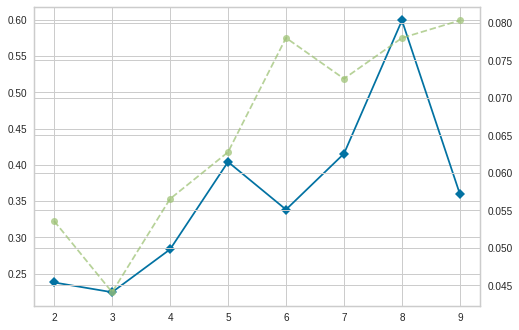

In [ ]:
from yellowbrick.cluster.elbow import KElbowVisualizer

# Use the quick method and immediately show the figure
visualizer = KElbowVisualizer(KMeans(), k=(2,10), metric='distortion', timings = True, locate_elbow = True)

visualizer.fit(hcm_grouped_clustering)

# **VISUALIZATION**

Visualize each cluster on Ho Chi Minh city Map

In [ ]:
# create map
map_clusters = folium.Map(location=[10.7758439, 106.7017555], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(atm_merged['latitude'], atm_merged['longitude'], 
                                  atm_merged['atm name'], atm_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# **FEATURES OF EACH CLUSTER**

In [ ]:
atm_merged[atm_merged['Cluster Labels'] == 0]

,Cluster Labels,atm name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,longitude,latitude
2,0,103. Techcombank Bình Thới,Café,Pizza Place,Flower Shop,Burrito Place,Yoga Studio,Diner,Fast Food Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,106.643,10.7683
4,0,112. Techcombank Đinh Bộ Lĩnh,Soup Place,Park,Café,Travel Agency,Dim Sum Restaurant,Fast Food Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Dive Bar,106.709,10.806
9,0,124. Techcombank Kỳ Hòa,Café,Coffee Shop,Vietnamese Restaurant,Steakhouse,Dessert Shop,Multiplex,Brewery,Bookstore,Korean Restaurant,Spa,106.668,10.7739
10,0,126. Techcombank Lê Đức Thọ,Café,Coffee Shop,Fast Food Restaurant,Supermarket,Diner,Flea Market,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Dive Bar,106.683,10.8321
29,0,162. Techcombank Tân Hưng Thuận,Café,Gym,Coffee Shop,Lounge,Seafood Restaurant,Yoga Studio,Dim Sum Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,106.626,10.8265
32,0,169. Techcombank Tây Sài Gòn,Coffee Shop,Café,Multiplex,Seafood Restaurant,Steakhouse,Electronics Store,Fried Chicken Joint,Hotel,Pizza Place,Flea Market,106.66,10.7963
39,0,178. Techcombank Trường Chinh,Café,Gym,Lounge,Department Store,Supermarket,Yoga Studio,Diner,Fast Food Restaurant,Electronics Store,Eastern European Restaurant,106.631,10.822
41,0,180. Techcombank Trương Vĩnh Ký,Café,Coffee Shop,BBQ Joint,Asian Restaurant,Flea Market,Warehouse Store,Vietnamese Restaurant,Fast Food Restaurant,Electronics Store,Eastern European Restaurant,106.633,10.7939
45,0,185. Tòa nhà Coteccons,Furniture / Home Store,Hotel,Art Gallery,Café,Yoga Studio,Flea Market,Fast Food Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,106.706,10.799
61,0,25. Techcombank Đường 3 tháng 2,Café,Vietnamese Restaurant,Spa,Coffee Shop,Seafood Restaurant,Music Venue,Restaurant,Ice Cream Shop,Vegetarian / Vegan Restaurant,Market,106.68,10.7754


In [ ]:
atm_merged[atm_merged['Cluster Labels'] == 1]

,Cluster Labels,atm name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,longitude,latitude
64,1,29. ATM Công ty Golf Việt Nam,Fountain,Yoga Studio,Diner,Flea Market,Fast Food Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Dive Bar,Dim Sum Restaurant,106.824,10.8417


In [ ]:
atm_merged[atm_merged['Cluster Labels'] == 2]

,Cluster Labels,atm name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,longitude,latitude
6,2,12. ATM thế hệ mới TCB Quang Trung (CRM - Nộp ...,Fast Food Restaurant,Supermarket,Japanese Restaurant,Bookstore,Vietnamese Restaurant,Yoga Studio,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Dive Bar,106.68,10.8265
7,2,12. ATM thế hệ mới TCB Quang Trung (CRM - Nộp ...,Fast Food Restaurant,Supermarket,Japanese Restaurant,Bookstore,Vietnamese Restaurant,Yoga Studio,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Dive Bar,106.68,10.8265
13,2,137. Techcombank Nguyễn Oanh,Fast Food Restaurant,Supermarket,Japanese Restaurant,Bookstore,Airport Service,Electronics Store,Diner,Flea Market,Eastern European Restaurant,Dumpling Restaurant,106.679,10.8282
23,2,155. Techcombank Quang Trung,Fast Food Restaurant,Supermarket,Japanese Restaurant,Bookstore,Vietnamese Restaurant,Yoga Studio,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Dive Bar,106.68,10.8265
44,2,184. Tòa An Hóc Môn,Market,Snack Place,Yoga Studio,Diner,Fast Food Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Dive Bar,Dim Sum Restaurant,106.599,10.8882
69,2,40. BIG C GO VAP - HCM,Flea Market,Bookstore,Vietnamese Restaurant,Market,Convention Center,Diner,Fast Food Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,106.679,10.8194
73,2,46. Co.opmart Phan Văn Trị,Supermarket,Bookstore,Fast Food Restaurant,Yoga Studio,Food,Flea Market,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Dive Bar,106.682,10.8295
94,2,85. Nhà sách Nguyễn Văn Cừ,Tailor Shop,Vietnamese Restaurant,Bookstore,Supermarket,Yoga Studio,Fast Food Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Dive Bar,106.714,10.8351
96,2,88. Nhà Thiếu Nhi Q Thủ Đức,Gym / Fitness Center,Fast Food Restaurant,Electronics Store,Multiplex,Shopping Mall,Diner,Eastern European Restaurant,Dumpling Restaurant,Dive Bar,Dim Sum Restaurant,106.767,10.8506
103,2,95. Techcombank Âu Cơ,Japanese Restaurant,Bakery,Park,Supermarket,Shopping Mall,Sporting Goods Shop,BBQ Joint,Movie Theater,Udon Restaurant,Ramen Restaurant,106.62,10.7999


In [ ]:
atm_merged[atm_merged['Cluster Labels'] == 3]

,Cluster Labels,atm name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,longitude,latitude
0,3,1. ATM Sở Xây Dựng,Vietnamese Restaurant,Café,Coffee Shop,Asian Restaurant,Vegetarian / Vegan Restaurant,Korean Restaurant,Music Venue,Gym / Fitness Center,Hotel,Sushi Restaurant,106.691,10.777
1,3,1. ATM Sở Xây Dựng,Vietnamese Restaurant,Café,Coffee Shop,Asian Restaurant,Vegetarian / Vegan Restaurant,Korean Restaurant,Music Venue,Gym / Fitness Center,Hotel,Sushi Restaurant,106.691,10.777
3,3,110. Techcombank Chợ Lớn,Coffee Shop,Dessert Shop,Breakfast Spot,Food Truck,Flea Market,Pizza Place,Cupcake Shop,Department Store,Design Studio,Flower Shop,106.645,10.7497
5,3,118. Techcombank Hòa Hưng,Shopping Mall,Plaza,Bakery,Park,Vietnamese Restaurant,Food,Hotel,Korean Restaurant,Café,Bus Station,105.78,10.0455
8,3,122. Techcombank Huỳnh Tấn Phát,Gym / Fitness Center,Restaurant,Food Service,Café,Baseball Field,Seafood Restaurant,Dim Sum Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,106.734,10.7249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,3,90. QUAN UY QUAN 10 - HCM,Vietnamese Restaurant,Coffee Shop,Café,Dessert Shop,Sushi Restaurant,Multiplex,Fast Food Restaurant,Bookstore,Market,Food Truck,106.667,10.768
100,3,91. Satra Đất Thành,Vietnamese Restaurant,Café,Pizza Place,Food,Diner,BBQ Joint,Asian Restaurant,Noodle House,Cupcake Shop,Gym / Fitness Center,106.682,10.8009
101,3,92. Siêu thị Điện Máy Chợ Lớn,Shopping Mall,Plaza,Bakery,Park,Vietnamese Restaurant,Food,Hotel,Korean Restaurant,Café,Bus Station,105.78,10.0455
102,3,93. Siêu Thị Lotte Mart,Vietnamese Restaurant,Pizza Place,Café,Sushi Restaurant,Fast Food Restaurant,Convenience Store,Noodle House,Restaurant,Asian Restaurant,Shopping Mall,106.702,10.7416


In [ ]:
atm_merged[atm_merged['Cluster Labels'] == 4]

,Cluster Labels,atm name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,longitude,latitude
30,4,163. Techcombank Tân Hương,Café,Flea Market,Diner,Yoga Studio,Dim Sum Restaurant,Fast Food Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Dive Bar,106.622,10.7958
35,4,171. Techcombank Thanh Đa,Café,Vietnamese Restaurant,Bakery,Yoga Studio,Diner,Flea Market,Fast Food Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,106.712,10.8076
36,4,174. Techcombank Thuận Kiều,Café,Yoga Studio,Dim Sum Restaurant,Flea Market,Fast Food Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Dive Bar,Diner,105.622,10.1131
49,4,190. Trung tâm Văn hóa Quận Bình Thạnh,Flea Market,Café,French Restaurant,Diner,Dim Sum Restaurant,Fast Food Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Dive Bar,106.696,10.7985
